In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

In [41]:
def summarize(alpha=0.05):
    
    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })
    
    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index()
    merged = pd.merge(
        df, source_data,
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


In [4]:
foxes = pd.read_csv('../data/foxes.csv', sep=';')
foxes.sample(5)

,group,avgfood,groupsize,area,weight
63,18,1.21,8,5.07,4.75
114,30,0.41,3,1.91,2.78
83,23,0.69,4,3.16,5.03
26,11,0.51,3,2.21,4.31
40,14,0.77,4,3.43,4.72


**H1** Fit two bivariate Gaussian regressions, using map: (1) body weight as a linear function of territory size (`area`), and (2) body weight as a linear function of `groupsize`. Plot the results of these regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable important for predicting fox body weight?

In [8]:
with pm.Model() as model_5h1_area:
    alpha = pm.Normal('alpha', mu=foxes.weight.mean(), sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)

    weight = pm.Deterministic(
        'weight',
        alpha + beta * (foxes.area - foxes.area.mean())
    )
    
    sigma = pm.HalfCauchy('sigma', beta=10)
    weight_obs = pm.Normal('weight_obs', mu=weight, sd=sigma,
                       observed=foxes.weight)

    model_5h1_area.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1270.21draws/s]


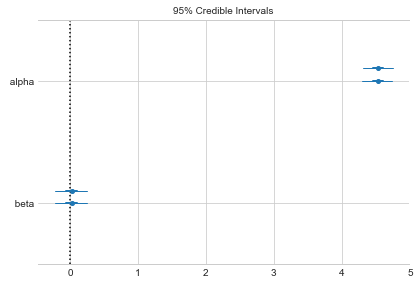

In [10]:
pm.forestplot(model_5h1_area.trace, varnames=['alpha', 'beta'], rhat=False)
None

In [12]:
with pm.Model() as model_5h1_groupsize:
    alpha = pm.Normal('alpha', mu=foxes.weight.mean(), sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)

    weight = pm.Deterministic(
        'weight',
         alpha + beta * (foxes.groupsize - foxes.groupsize.mean()))

    sigma = pm.HalfCauchy('sigma', beta=10)
    weight_obs = pm.Normal('weight_obs', mu=weight, sd=sigma,
                       observed=foxes.weight)

    model_5h1_groupsize.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1306.50draws/s]


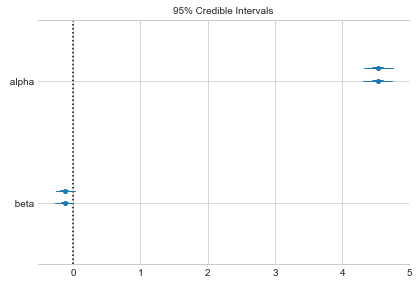

In [19]:
pm.forestplot(model_5h1_groupsize.trace, varnames=['alpha', 'beta'], rhat=False)
None

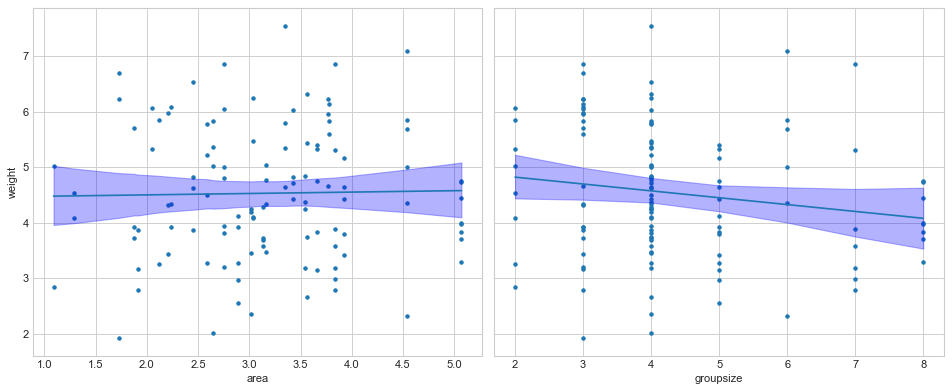

In [51]:
weight_area = agg_prediction(model_5h1_area.trace['weight'], foxes,
                             ['area'], summarize(0.05))
weight_groupsize = agg_prediction(model_5h1_groupsize.trace['weight'], foxes,
                                  ['groupsize'], summarize(0.05))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=80, sharey=True)

ax1.scatter(foxes.area, foxes.weight, marker='.')

ax1.plot(weight_area.area, weight_area.mean_)
ax1.fill_between(weight_area.area,
                 weight_area.lower, weight_area.upper,
                 alpha=.3, color='b')
ax1.set_xlabel('area')
ax1.set_ylabel('weight')

ax2.scatter(foxes.groupsize, foxes.weight, marker='.')

ax2.plot(weight_groupsize.groupsize, weight_groupsize.mean_)
ax2.fill_between(weight_groupsize.groupsize,
                 weight_groupsize.lower, weight_groupsize.upper,
                 alpha=.3, color='b')
ax2.set_xlabel('groupsize')

fig.tight_layout()
None

**H2** Now fit a multiple linear regression with weight as the outcome and both area and groupsize as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant at its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise just above?

In [26]:
with pm.Model() as model_5h2:
    alpha = pm.Normal('alpha', mu=foxes.weight.mean(), sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)

    weight = pm.Deterministic(
        'weight',
        alpha
        + beta[0] * (foxes.area - foxes.area.mean())
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    weight_obs = pm.Normal('weight_obs', mu=weight, sd=sigma,
                           observed=foxes.weight)

    weight_area = pm.Deterministic(
        'weight_area',
        alpha
        + beta[0] * (foxes.area - foxes.area.mean())
    )
    weight_groupsize = pm.Deterministic(
        'weight_groupsize',
        alpha
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
    )
    
    model_5h2.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:14<00:00, 807.91draws/s]


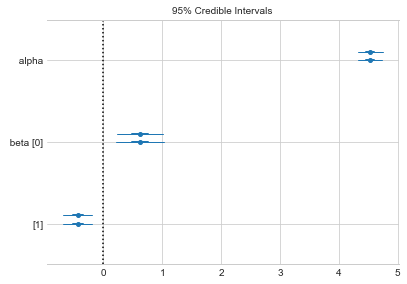

In [30]:
pm.forestplot(model_5h2.trace, varnames=['alpha', 'beta'], rhat=False)
None

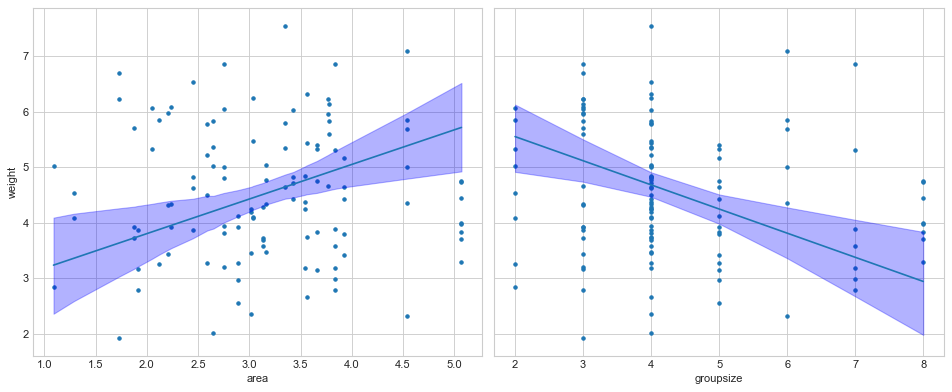

In [52]:
weight_area = agg_prediction(model_5h2.trace['weight_area'], foxes,
                             ['area'], summarize(0.05))
weight_groupsize = agg_prediction(model_5h2.trace['weight_groupsize'], foxes,
                                  ['groupsize'], summarize(0.05))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=80, sharey=True)

ax1.scatter(foxes.area, foxes.weight, marker='.')

ax1.plot(weight_area.area, weight_area.mean_)
ax1.fill_between(weight_area.area,
                 weight_area.lower, weight_area.upper,
                 alpha=.3, color='b')
ax1.set_xlabel('area')
ax1.set_ylabel('weight')

ax2.scatter(foxes.groupsize, foxes.weight, marker='.')

ax2.plot(weight_groupsize.groupsize, weight_groupsize.mean_)
ax2.fill_between(weight_groupsize.groupsize,
                 weight_groupsize.lower, weight_groupsize.upper,
                 alpha=.3, color='b')
ax2.set_xlabel('groupsize')

fig.tight_layout()
None

**H3.** Finally, consider the `avgfood` variable. Fit two more multiple regressions: (1) body weight as an additive function of `avgfood` and `groupsize`, and (2) body weight as an additive function of all three variables, `avgfood` and `groupsize` and `area`. 

In [53]:
with pm.Model() as model_5h3_1:
    alpha = pm.Normal('alpha', mu=foxes.weight.mean(), sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)

    weight = pm.Deterministic(
        'weight',
        alpha
        + beta[0] * (foxes.avgfood - foxes.avgfood.mean())
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    weight_obs = pm.Normal('weight_obs', mu=weight, sd=sigma,
                           observed=foxes.weight)

    weight_avgfood = pm.Deterministic(
        'weight_avgfood',
        alpha
        + beta[0] * (foxes.avgfood - foxes.avgfood.mean())
    )
    weight_groupsize = pm.Deterministic(
        'weight_groupsize',
        alpha
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
    )
    
    model_5h3_1.trace = pm.sample(5000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:19<00:00, 605.37draws/s]


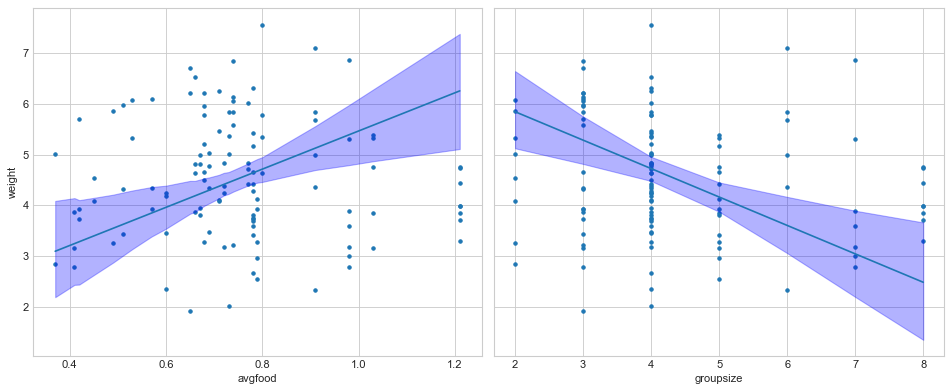

In [54]:
weight_avgfood = agg_prediction(model_5h3_1.trace['weight_avgfood'], foxes,
                                ['avgfood'], summarize(0.05))
weight_groupsize = agg_prediction(model_5h3_1.trace['weight_groupsize'], foxes,
                                  ['groupsize'], summarize(0.05))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=80, sharey=True)

ax1.scatter(foxes.avgfood, foxes.weight, marker='.')

ax1.plot(weight_avgfood.avgfood, weight_avgfood.mean_)
ax1.fill_between(weight_avgfood.avgfood,
                 weight_avgfood.lower, weight_avgfood.upper,
                 alpha=.3, color='b')
ax1.set_xlabel('avgfood')
ax1.set_ylabel('weight')

ax2.scatter(foxes.groupsize, foxes.weight, marker='.')

ax2.plot(weight_groupsize.groupsize, weight_groupsize.mean_)
ax2.fill_between(weight_groupsize.groupsize,
                 weight_groupsize.lower, weight_groupsize.upper,
                 alpha=.3, color='b')
ax2.set_xlabel('groupsize')

fig.tight_layout()
None

In [56]:
with pm.Model() as model_5h3_2:
    alpha = pm.Normal('alpha', mu=foxes.weight.mean(), sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)

    weight = pm.Deterministic(
        'weight',
        alpha
        + beta[0] * (foxes.avgfood - foxes.avgfood.mean())
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
        + beta[2] * (foxes.area - foxes.area.mean())
    )

    sigma = pm.HalfCauchy('sigma', beta=10)
    weight_obs = pm.Normal('weight_obs', mu=weight, sd=sigma,
                       observed=foxes.weight)

    weight_avgfood = pm.Deterministic(
        'weight_avgfood',
        alpha
        + beta[0] * (foxes.avgfood - foxes.avgfood.mean())
    )
    weight_groupsize = pm.Deterministic(
        'weight_groupsize',
        alpha
        + beta[1] * (foxes.groupsize - foxes.groupsize.mean())
    )
    weight_area = pm.Deterministic(
        'weight_area',
        alpha
        + beta[2] * (foxes.area - foxes.area.mean())
    )
    
    model_5h3_2.trace = pm.sample(5000, tune=1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:27<00:00, 434.93draws/s]


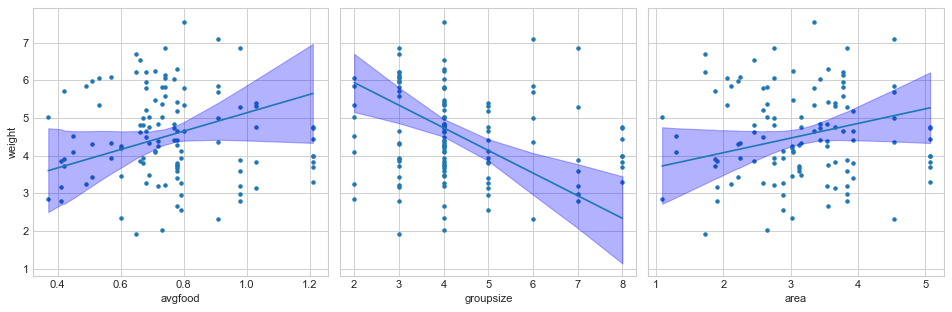

In [61]:
weight_avgfood = agg_prediction(model_5h3_2.trace['weight_avgfood'], foxes,
                                ['avgfood'], summarize(0.05))
weight_groupsize = agg_prediction(model_5h3_2.trace['weight_groupsize'], foxes,
                                  ['groupsize'], summarize(0.05))
weight_area = agg_prediction(model_5h3_2.trace['weight_area'], foxes,
                             ['area'], summarize(0.05))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=80, sharey=True)

ax1.scatter(foxes.avgfood, foxes.weight, marker='.')

ax1.plot(weight_avgfood.avgfood, weight_avgfood.mean_)
ax1.fill_between(weight_avgfood.avgfood,
                 weight_avgfood.lower, weight_avgfood.upper,
                 alpha=.3, color='b')
ax1.set_xlabel('avgfood')
ax1.set_ylabel('weight')

ax2.scatter(foxes.groupsize, foxes.weight, marker='.')

ax2.plot(weight_groupsize.groupsize, weight_groupsize.mean_)
ax2.fill_between(weight_groupsize.groupsize,
                 weight_groupsize.lower, weight_groupsize.upper,
                 alpha=.3, color='b')
ax2.set_xlabel('groupsize')

ax3.scatter(foxes.area, foxes.weight, marker='.')

ax3.plot(weight_area.area, weight_area.mean_)
ax3.fill_between(weight_area.area,
                 weight_area.lower, weight_area.upper,
                 alpha=.3, color='b')
ax3.set_xlabel('area')

fig.tight_layout()
None

Compare the results of these models to the previous models you’ve fit, in the first two exercises. (a) Is `avgfood` or area a better predictor of body weight? If you had to choose one or the other to include in a model, which would it be? Support your assessment with any tables or plots you choose. 

5H2 model


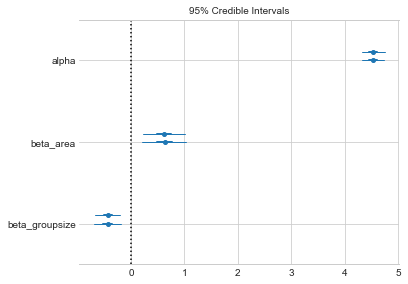

In [63]:
pm.forestplot(model_5h2.trace, varnames=['alpha', 'beta'], rhat=False,
              ylabels=['alpha', 'beta_area', 'beta_groupsize'])
print('5H2 model')

5H3_1 model


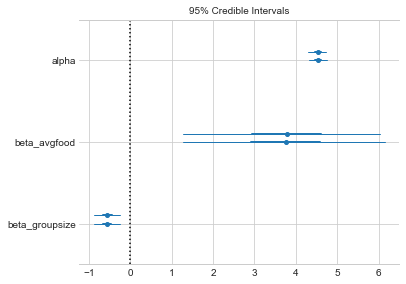

In [65]:
pm.forestplot(model_5h3_1.trace, varnames=['alpha', 'beta'], rhat=False,
              ylabels=['alpha', 'beta_avgfood', 'beta_groupsize'])
print('5H3_1 model')

5H3_2 model


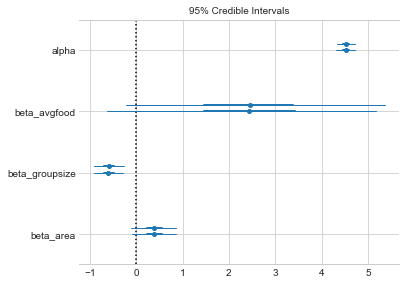

In [66]:
pm.forestplot(model_5h3_2.trace, varnames=['alpha', 'beta'], rhat=False,
              ylabels=['alpha', 'beta_avgfood', 'beta_groupsize', 'beta_area'])
print('5H3_2 model')